# Algorithm #1 Implementation

## Library Imports

In [1]:
import numpy as np 
import cv2
from skimage.color import rgb2ycbcr, ycbcr2rgb
from skimage.transform import resize
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

import numpy as np 
from skimage.transform import resize
from scipy.signal import convolve2d
from tqdm import tqdm


## Feature Sign Algorithm for Quadratic Programming

In [2]:
def featureSign(y: np.ndarray, A: np.ndarray, lamb):
    EPS = 1e-9 #epsilon for comparisons
    
    x = np.zeros((A.shape[1], 1)) #initialize x
    theta = np.sign(x) #initialize theta
    y = y.reshape((-1, 1)) #reshape y to a column vector for ease of calculations
    gradient = (2 * (A.T @ A @ x)) - (2 * (A.T @ y))  #initial value of gradient 
    active_set = np.zeros(shape = x.shape) #initialize active set
    
    #Iterate
    for _ in range(10):
        gradient_max_idx = np.argmax(np.abs(gradient) * (x == 0))
        Ai = A[:, gradient_max_idx].flatten().reshape((-1, 1))
        
        if gradient[gradient_max_idx] > lamb + EPS:
            x[gradient_max_idx] = (lamb - gradient[gradient_max_idx]) / (2 * (np.linalg.norm(Ai) ** 2))
            theta[gradient_max_idx] = -1
            active_set[gradient_max_idx] = 1
        elif gradient[gradient_max_idx] < -lamb - EPS:
            x[gradient_max_idx] = (-lamb - gradient[gradient_max_idx]) / (2 * (np.linalg.norm(Ai) ** 2))
            theta[gradient_max_idx] = 1
            active_set[gradient_max_idx] = 1
        else:
            if np.all(x == 0):
                break
        
        #Feature-Sign Step
        for _ in range(10):
            x_non_zero_idxes = (x != 0).flatten()
            A_hat = A[:, x_non_zero_idxes]
            x_hat = x[x_non_zero_idxes, :]
            theta_hat = theta[x_non_zero_idxes, :]
            
            x_hat_new = np.linalg.lstsq(A_hat.T @ A_hat, A_hat.T @ y - 0.5 * lamb * theta_hat, rcond=None)[0]            
            loss_new = np.linalg.norm(y - A_hat @ x_hat_new) ** 2 + lamb * np.sum(abs(x_hat_new))
            
            idx_hats = np.where(x_hat * x_hat_new < 0) [0]
            if np.all(idx_hats == 0):
                x_hat = x_hat_new
                
                x[x_non_zero_idxes, :] = x_hat
                theta = np.sign(x)
                active_set = (x != 0)
                
            else:
                x_min = x_hat_new
                loss_min = loss_new
                diff = x_min - x_hat
                delta = diff / x_hat
                
                for zd in idx_hats.T:
                    x_s = x_hat - diff / delta[zd]
                    x_s[zd] = 0
                    x_s_idx = (x_s == 0).flatten()
                    
                    A_hat_s_idx = A_hat[:, x_s_idx]
                    x_s_modified = x_s[x_s_idx, :]
                    
                    loss = np.linalg.norm(y - A_hat_s_idx @ x_s_modified) ** 2 + lamb * np.sum(abs(x_s_modified))
                    if loss < loss_min:
                        x_min = x_s
                        loss_min = loss
                
                x[x_non_zero_idxes, :] = x_min
                theta = np.sign(x)
                active_set = (x != 0)     
            
            gradient = (2 * (A.T @ A @ x)) - (2 * (A.T @ y))
            non_zero_idxs = (x != 0).flatten()
            if np.all(gradient[non_zero_idxs, :] + lamb * theta[non_zero_idxs, :] == 0):
                break
            
        zero_idxs = (x == 0).flatten()
        if np.all(gradient[zero_idxs, :] <= lamb):
            break
                    
    return x

## Super Resolution Algorithm

In [3]:
#Compute Features using First and Second Order Gradient Filters
def F(img_lr: np.ndarray):
    h, w = img_lr.shape
    img_lr_feat = np.zeros((h, w, 4))

    # First order gradient filters
    hf1 = [[-1, 0, 1], ] * 3
    vf1 = np.transpose(hf1)

    img_lr_feat[:, :, 0] = convolve2d(img_lr, hf1, 'same')
    img_lr_feat[:, :, 1] = convolve2d(img_lr, vf1, 'same')

    # Second order gradient filters
    hf2 = [[1, 0, -2, 0, 1], ] * 3
    vf2 = np.transpose(hf2)

    img_lr_feat[:, :, 2] = convolve2d(img_lr, hf2, 'same')
    img_lr_feat[:, :, 3] = convolve2d(img_lr, vf2, 'same')

    return img_lr_feat

def lin_scale(xh, us_norm):
    hr_norm = np.linalg.norm(xh)

    if hr_norm > 0:
        s = us_norm * 1.2 / hr_norm
        xh *= s
    return xh

def SR(img_lr_y, size, upscale, Dh, Dl, lmbd, overlap):
    patch_size = 5

    #Upsample the low resolution image
    img_us = resize(img_lr_y, size)
    img_us_height, img_us_width = img_us.shape
    
    #Initialize the high resolution image
    img_hr = np.zeros(img_us.shape)
    cnt_matrix = np.zeros(img_us.shape)

    #Extract first order and second order gradients from the upscaled, low resolution image
    img_lr_y_feat = F(img_us)

    #Create a grid over which we can obtain all the patches
    gridx = np.append(np.arange(0, img_us_width - patch_size - 1, patch_size - overlap), img_us_width - patch_size - 1)
    gridy = np.append(np.arange(0, img_us_height - patch_size - 1, patch_size - overlap), img_us_height - patch_size - 1)

    count = 0

    #Iterate over each point in the grid
    for m in tqdm(range(0, len(gridx))):
        for n in range(0, len(gridy)):
            count += 1
            xx = int(gridx[m])
            yy = int(gridy[n])

            #Get Upsampled patch from the Low Res Image
            us_patch = img_us[yy : yy + patch_size, xx : xx + patch_size]
            us_mean = np.mean(us_patch)
            us_patch = us_patch.flatten(order='F') - us_mean
            us_norm = np.linalg.norm(us_patch)

            #Get Feature Patch from Gradient Patch
            feat_patch = img_lr_y_feat[yy : yy + patch_size, xx : xx + patch_size, :]
            feat_patch = feat_patch.flatten(order='F')
            feat_norm = np.linalg.norm(feat_patch)
            
            #Normalize Feature Patch if needed
            if feat_norm > 1:
                y = feat_patch / feat_norm
            else:
                y = feat_patch
                
            w = featureSign(y, Dl, lmbd)

            hr_patch = Dh @ w
            hr_patch = lin_scale(hr_patch, us_norm)

            hr_patch = np.reshape(hr_patch, (patch_size, -1))
            hr_patch += us_mean

            img_hr[yy : yy + patch_size, xx : xx + patch_size] += hr_patch
            cnt_matrix[yy : yy + patch_size, xx : xx + patch_size] += 1

    index = np.where(cnt_matrix < 1)[0]
    img_hr[index] = img_us[index]
    cnt_matrix[index] = 1
    img_hr = np.divide(img_hr, cnt_matrix)
    return img_hr

## Backprojection Algorithm

In [4]:
def gauss2D(shape,sigma):
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def backprojection(img_hr, img_lr, maxIter):
    p = gauss2D((5, 5), 1)
    p = np.multiply(p, p)
    p = np.divide(p, np.sum(p))

    for i in range(maxIter):
        img_lr_ds = resize(img_hr, img_lr.shape, anti_aliasing=1)
        img_diff = img_lr - img_lr_ds

        img_diff = resize(img_diff, img_hr.shape)
        img_hr += convolve2d(img_diff, p, 'same')
    return img_hr

## Execution!

100%|██████████| 128/128 [34:41<00:00, 16.27s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


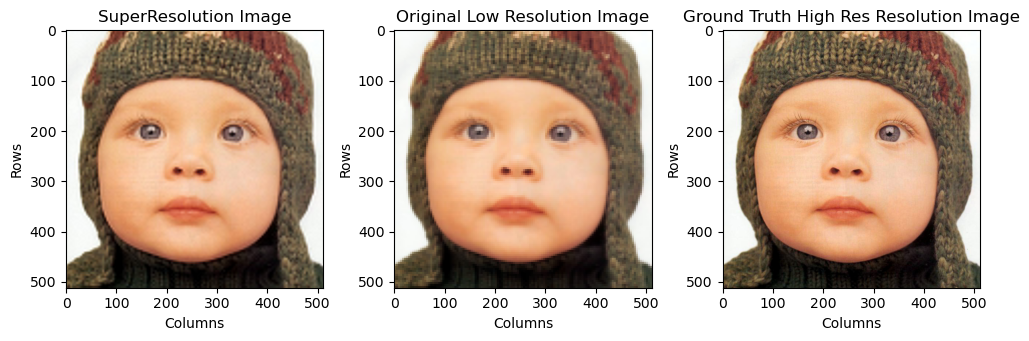

In [5]:
# Set which dictionary you want to use    
Dh = np.load("../Dictionaries/Dh.npy")
Dl = np.load("../Dictionaries/Dl.npy")

Dh = normalize(Dh)
Dl = normalize(Dl)

### SET PARAMETERS
lmbd = 0.1
patch_size= 5
D_size = 512
US_mag = 3

overlap = 1
lmbd = 0.1
upscale = 4
maxIter = 100

lr_image_path = "../Data/Testing/Child.png"
hr_image_path = "../Data/Testing/Child_gnd.bmp"

#Read Low Resolution Image. Cv2 reads in BGR order so must be flipped! 
img_lr = cv2.imread(lr_image_path)
img_lr_ori = img_lr #store original low resolution image
img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)

# Read and save ground truth image[High Resolution Image]
img_hr = cv2.imread(hr_image_path)
img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)

# Change color space for Low Res and High Res Image
img_hr_y = rgb2ycbcr(img_hr)[:, :, 0] #Get Convert RGB to Y, CB, Cr and get Y component for High Resolution Image

img_lr = rgb2ycbcr(img_lr) #Get Convert RGB to Y, CB, Cr for Low Resolution Image
img_lr_y = img_lr[:, :, 0] #Y Component
img_lr_cb = img_lr[:, :, 1] #CB Component
img_lr_cr = img_lr[:, :, 2] #Cr Component

# Upscale chrominance to color SR images
img_sr_cb = resize(img_lr_cb, (img_hr.shape[0], img_hr.shape[1]), order=0)
img_sr_cr = resize(img_lr_cr, (img_hr.shape[0], img_hr.shape[1]), order=0)

# Super Resolution via Sparse Representation
img_sr_y = SR(img_lr_y, img_hr_y.shape, upscale, Dh, Dl, lmbd, overlap)
img_sr_y = backprojection(img_sr_y, img_lr_y, maxIter)
    
# Create colored SR images
img_sr = np.stack((img_sr_y, img_sr_cb, img_sr_cr), axis=2)
img_sr = ycbcr2rgb(img_sr)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

axes[0].imshow(img_sr)  # You can choose different colormaps ('gray' for grayscale)
axes[0].set_title('SuperResolution Image')  # Set title
axes[0].set_xlabel('Columns')  # Set label for x-axis
axes[0].set_ylabel('Rows')  # Set label for y-axis

axes[1].imshow(resize(cv2.cvtColor(img_lr_ori, cv2.COLOR_BGR2RGB), (img_hr.shape[0], img_hr.shape[1]), order = 0), cmap='gray')  # You can choose different colormaps ('gray' for grayscale)
axes[1].set_title('Original Low Resolution Image')  # Set title
axes[1].set_xlabel('Columns')  # Set label for x-axis
axes[1].set_ylabel('Rows')  # Set label for y-axis


axes[2].imshow(img_hr, cmap='gray')  # You can choose different colormaps ('gray' for grayscale)
axes[2].set_title('Ground Truth High Res Resolution Image')  # Set title
axes[2].set_xlabel('Columns')  # Set label for x-axis
axes[2].set_ylabel('Rows')  # Set label for y-axis

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the figure with subplots